In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
mu1 = 2.5
mu2 = 7.5
sigma1 = 0.75
sigma2 = 1

pi1 = 0.3
pi2 = 0.7

In [3]:
norm1 = norm(mu1, sigma1)
norm2 = norm(mu2, sigma2)
n_pdf = lambda x: pi1 * norm1.pdf(x) + pi2 * norm2.pdf(x)

In [4]:
X = np.linspace(-5, 20, 1000)

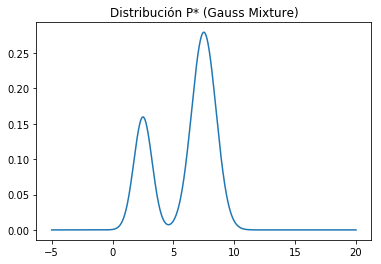

In [165]:
y1 = n_pdf(X)
plt.plot(X, y1)
plt.title('Distribución P* (Gauss Mixture)')
plt.show()

Se observa que tiene los _peaks_ en las zonas correspondientes a las medias de cada una de las dos normales originales. También que el ancho de esas áreas de mayor densidad depende de la varianza, y que el valor de $\pi$ influye directamente en el alto de dichos _peaks_.

La gracia es que al sumar 1 ambos $\pi$, se aprecia que integrará 1, por lo tanto se interpreta como una distribución de probabilidades.

In [166]:
def stepping_out(x, w, u):
    r = np.random.uniform(0, 1)
    xl, xr = x - r * w, x + (1 - r) * w
    while n_pdf(xl) > u:
        xl -= w
    while n_pdf(xr) > u:
        xr += w
    return xl, xr

def shrink_interval(xl, xr, x, x_):
    if x_ > x:
        xr = x_
    else:
        xl = x_
    return xl, xr

def slice_sampling(p, x0, w, n):
    samples = []
    while len(samples) < n:
        u_ = np.random.uniform(0, p(x0))
        xl, xr = stepping_out(x0, w, u_)
        while True:
            x_ = np.random.uniform(xl, xr)
            if p(x_) > u_:
                x0 = x_
                samples.append(x_)
                break
            else:
                xl, xr = shrink_interval(xl, xr, x0, x_)
    return samples

In [167]:
x0 = np.random.uniform(-5, 20)
w = 1
n = 1000
y3 = slice_sampling(n_pdf, x0, w, n)

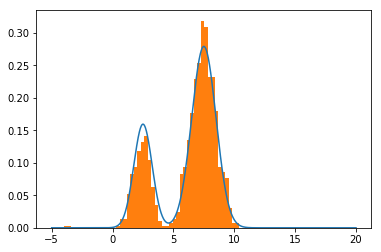

In [168]:
plt.plot(X, y1)
plt.hist(y3, density=True, bins=50)
plt.show()

Se observa que el histograma como densidad calza bastante a pesar de ser pocas muestras (1000). Se utilizó una técnica que es utilizar la última muestra como punto de partida para el siguiente muestreo, esto hace el procedimiento markoviano, aparte de que hace que el _fit_ sea bastante bueno.

Es importante notar que el método no es muy robusto a cambios de varianza y media, por ejemplo si los $\sigma$'s son muy chicos y las medias muy separadas, ocurrirá que cuando se genere $u$ para elegir el alto o la componente $y$, esta nunca será menor que 0 y por ende no podrá ir de un _peak_ a otro de la distribución.

In [174]:
def slice_sampling_for_animation(p, x0, w, n):
    samples = []
    intervals = []
    
    while len(samples) < n:
        u_ = np.random.uniform(0, p(x0))
        xl, xr = stepping_out(x0, w, u_)
        while True:
            x_ = np.random.uniform(xl, xr)
            val_ = p(x_)
            intervals.append([x0, xl, xr, u_, x_])
            if val_ > u_:
                x0 = x_
                samples.append(x_)
                break
            else:
                xl, xr = shrink_interval(xl, xr, x0, x_)
    return samples, intervals

Se agrega esta función que guarda los datos necesarios para hacer la animación.

In [175]:
%matplotlib inline
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [176]:
samples, intervals = slice_sampling_for_animation(n_pdf, x0, w, n)

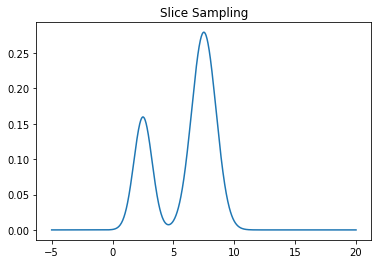

In [183]:
fig, ax = plt.subplots();
xdata, ydata = [], [];
dots, = plt.plot([], [], 'bo');
dots2, = plt.plot([], [], 'ko');
lines, = plt.plot([], [], 'g-');

def init():
    ax.set_xlim(-5, 20)
    ax.set_ylim(0, 0.4)
    return dots, dots2, lines

def update(frame):
    x, xl, xr, u, x_ = intervals[frame]
    xx = np.linspace(xl, xr, 40)
    dots.set_data([x], [n_pdf(x)])
    dots2.set_data([x_], [n_pdf(x_)])
    lines.set_data(xx, xx * 0 + u)
    ax.legend(['x', '$x^*$', 'interval'])
    return dots, dots2, lines

ax.set_title('Slice Sampling')
ax.plot(X, y1);

In [184]:
ani = FuncAnimation(fig, update, frames=np.arange(40), init_func=init, blit=True);
HTML(ani.to_jshtml())

En la animación se aprecia como el intervalo se va achicando hasta que es aceptada la muestra. Se recomienda utilizar el "-" para reducir la velocidad.